#### Использованные библиотеки

In [4]:
!pip install -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision.datasets import MNIST, FashionMNIST

import wandb
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader

from pl_base import BestValidCallback
from datagen import SubLoader, TaskAugmentor
from models import GPT
from utils import gpt_params, g_transform

import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

torch.set_float32_matmul_precision('medium')
device = "cuda" if torch.cuda.is_available() else "cpu"
device

C:\Users\Maloy\Documents\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



'cpu'

### Учимся учиться

#### Setup

Одна из самых интересных вещей в этой статье - то, что трансформер, если ему дать достаточно много задач, начинает не просто запоминать задачи, а вычленять общие закономерности, чтобы решать такие задачи, которых он ещё не видел. Мы будем смотреть это через такой же метатест, что и в `3. Metatrain.ipynb`. Вкратце: даём модели последовательность в 99 примеров, смотрим на качество на 100-м. Разнциа лишь в том, что интересует нас теперь лишь трансформер, а также смотреть будем не только на 100-й пример, но и на аккураси в целом по мере обработки последовательности

На картинке ниже показан график улучшения аккураси в зависимости от числа тасок. Суть здесь в том, что аккураси у каждого отдельного элемента последовательности может быть сколь угодно высокий, например `[0.9., 1., 0.9, 1.]`, но значимое улучшение составит лишь 0.1, модель не научилась обрабатывать таску в совокупности, она просто запомнила какое-то оптимальное решение задачи. Если же улучшение наоборот большое, то модель хорошо обобщает и вне зависимости от последовательности выдаёт правильный ответ, потому что научилась учиться. Чем больше тасок, тем больше эффект, фазовый переход происходит примерно на числе в $2^{13}$

<img src="src/seq_improv_ref.png" width="500px">

Помимо этого посмотрим на сам график улучшения аккураси. В случае трансформера это можно сделать через маску - так, чтобы модель видела лишь часть данных при предсказании, а аккураси будет означать качество на 100-м лейбле. Если качество растёт, хоть как-то, то модель научилась извлекать информацию из последовательности - то есть научилась учиться. В нашем сетапе будем делать это для трансформера на $2^{16}$ тасках, как и в статье

<img src="src/per_seq_acc_ref.png" width="500px">

Конфиг, трансформы и датасеты здесь такие же, как в предыдущих экспериментах, как самые удачные. Нам понадобится 3 валидации: MNIST с теми же тасками, MNIST с новыми тасками и FashionMNIST с новыми тасками. Учиться будем либо на MNIST, либо на FashionMNIST

#### Train

In [ ]:
mnist_test = SubLoader(MNIST('./datasets', train=True, transform=g_transform))
fashion_mnist_test = SubLoader(FashionMNIST('./datasets', train=True, transform=g_transform))

Для подсчёта аккураси понадобится кастомная функция. Она генерирует маски до $i$-го токена, делает предсказание модели, имея в виду лишь $i$ токенов, подсчитывает качество для каждого $i$ и его общий прирост - разница в аккураси между обучением на 99 и обучением на 1

In [147]:
def seq_accuracy(model, loader):
    res = torch.zeros(99)
    for i in range(99):
        attention_mask = torch.zeros(len(loader), 100)
        attention_mask[:, :i] = 1
        pred = F.softmax(
            model(loader.dataset.data, attention_mask=attention_mask), 1
        ).argmax(1)
        res[i] += (pred[:, -1] == loader.dataset.targets[:, -1]).float().mean()
    return res, res[-1] - res[0]

Логику вытаскивания даталоадеров лучше сразу засунуть в функцию. Её лучше вообще не менять. Число тасок в тесте это более изящный способ фиксации сида - оцениваем по каждой, затем усредняем

In [ ]:
def augment_data(
    n_tasks, draw_sequence, batch_size, train_dataset, seed
):
    train_samples = 1
    train_augmentor = TaskAugmentor(n_tasks, draw_sequence=True, random_state=seed)
    seen_augmentor = TaskAugmentor(256, draw_sequence=True, random_state=seed)
    unseen_augmentor = TaskAugmentor(256, draw_sequence=True, random_state=seed+1)
    train_loader = DataLoader(
        train_augmentor.transform(train_dataset, train_samples),
        batch_size=batch_size, shuffle=True
    )
    valid_loader = DataLoader(
        seen_augmentor.transform(mnist_test, 1),
        batch_size=1, shuffle=False
    )
    test_loader = DataLoader(
        unseen_augmentor.transform(mnist_test, 1),
        batch_size=1, shuffle=False
    )
    test_fashion_loader = DataLoader(
        unseen_augmentor.transform(fashion_mnist_test, 1),
        batch_size=1, shuffle=False
    )
    return train_loader, valid_loader, test_loader, test_fashion_loader

Функция ниже запускает обучение и логгирует результаты на wandb, [там](https://wandb.ai/lerostre/gpicl?workspace=user-lerostre) можно на них полюбоваться. Ключевая проблема - модели реально долго учить, они выходят на плато, поэтому EarlyStopping. результаты как обычно в датафрейм. Я запускал только для одного сида, потому что нету времени, а результаты и так видно

Основные параметры - трейн, у нас их 2, число тасок для перебора, таски, на которых замеряем улучшение аккураси, батч сайз для даталоадера, куда сохранять 100-е аккураси, куда сохранять аккураси от 1 до 99, сид, и конфиг для трансформера

In [149]:
def train_for_sequence_improvement(
    train_dataset: SubLoader,
    n_tasks_list: np.ndarray = 2**np.arange(0, 19),
    n_tasks_for_full_check: int = [2**16],
    batch_size: int = 128,
    output_csv: str = "last_acc.csv",
    seq_res_output: str = "mnist_seq_acc",
    random_state: int = 69,
    gpt_params = gpt_params,
    log=True
):
    logs = []
    for n_tasks in n_tasks_list:

        wandb_logger = None
        if log:
            # change if necessary
            wandb.init(project="gpicl", name=f"gpt_2^{int(np.log2(n_tasks))}", tags=["gpt"])
            wandb_logger = WandbLogger(log_model=False)
        # get loaders=[train, "seen_mnist", "unseen_mnist", "unseen_fashion_mnist"]
        loaders = augment_data(
            n_tasks, draw_sequence=True, seed=random_state,
            batch_size=batch_size, train_dataset=train_dataset
        )
        model_name, model = "gpt", GPT(**gpt_params)

        # training loop, free to adjust
        trainer = pl.Trainer(
            precision="16",
            accelerator="gpu",
            logger=wandb_logger,
            enable_progress_bar=not log,
            max_steps=100000,
            enable_model_summary=False,
            callbacks=[EarlyStopping(
                monitor="train_accuracy",
                min_delta=0.025,
                patience=100,
                mode="max"
            )]
        )
        trainer.fit(model, loaders[0], loaders[1:])

        # dataframe store
        for idx, name in enumerate([
            "seen_mnist", "unseen_mnist", "unseen_fashion_mnist"
        ]):
            seq_acc, last_acc = seq_accuracy(model, loaders[idx+1])
            if n_tasks in n_tasks_for_full_check:
                prefix = f"experiments/{seq_res_output}_{n_tasks}"
                np.save(prefix+"_"+name, seq_acc)
            entry = {
                "n_tasks": n_tasks, "dataset": name,
                "last_acc": last_acc.item(),
            }
            logs.append(entry)
            pd.DataFrame(logs).to_csv(f"experiments/{output_csv}", index=0)
        clear_output(True)

Сначала запустить для MNIST, потом для FashionMNIST, вот и вся задача. Самое сложное - дождаться

In [ ]:
mnist_train = SubLoader(MNIST('./datasets', train=True, transform=g_transform)) 
train_for_sequence_improvement(mnist_train)

In [ ]:
mnist_train = SubLoader(FashionMNIST('./datasets', train=True, transform=g_transform)) 
train_for_sequence_improvement(
    train_dataset=mnist_train,
    n_tasks_list=[2**16]
)

#### Интерпретация

Теперь будем строить графики по порядку

In [10]:
import pandas as pd

set_mapper = {
    "seen_mnist": "Seen MNIST",
    "unseen_mnist": "Unseen MNIST",
    "unseen_fashion_mnist": "Unseen FashionMNIST"
}
df = pd.read_csv("experiments/last_acc.csv")
df["dataset"] = df.dataset.map(set_mapper)

In [11]:
import plotly.express as px

fig = px.line(
    df, "n_tasks", "last_acc", color="dataset",
    color_discrete_sequence=["crimson", "midnightblue", "goldenrod"]
)
fig.update_xaxes(
    type='category', tickvals=df.n_tasks.values,
    ticktext = [f"$2^{{{int(np.log2(i))}}}$" for i in df.n_tasks.values]
)
fig.update_layout(
    legend=dict(
        x=0.10,
        y=0.80,
        bgcolor="white",
        bordercolor="Black",
        borderwidth=2,
        title="Dataset"
    ),
    width=725, height=500, title="Ability to learn per number of tasks",
    yaxis=dict(title="Accuracy improvement in sequence"),
    xaxis=dict(title="Number of tasks"),
)
fig.add_vrect(
    x0=0, x1=10, 
    annotation_text="Instance memorization", annotation_position="top right",
    fillcolor="gold", opacity=0.05, line_width=0,
    label=dict(font=dict(size=12)),
)
fig.add_vrect(
    x0=10, x1=14, 
    annotation_text="Task memorization", annotation_position="top right",
    fillcolor="blue", opacity=0.05, line_width=0,
    label=dict(font=dict(size=12)),
)
fig.add_vrect(
    x0=14, x1=18, 
    annotation_text="Learning to learn", annotation_position="top left",
    fillcolor="red", opacity=0.05, line_width=0,
    label=dict(font=dict(size=12)),
)
fig.show()

В целом график получается очень похожим, только качество слегка ниже, чем в статье. Но самое главное мы видим - модель действительно учится обощать при растущем количестве тасок. Посмотрим теперь, как она учится в процессе обработки последовательности

In [6]:
from glob import glob

res = []
for array in glob("experiments/*.npy"):
    trained_on, _, dataset = array.split("__")
    df = pd.DataFrame(np.load(array))
    df[["trained_on", "dataset"]] = trained_on.split("\\")[1], dataset.split(".")[0]
    res.append(df)
res = pd.concat(res)
res["daataset"] = res.dataset.map(set_mapper)
res = res[res.dataset != "seen_mnist"]

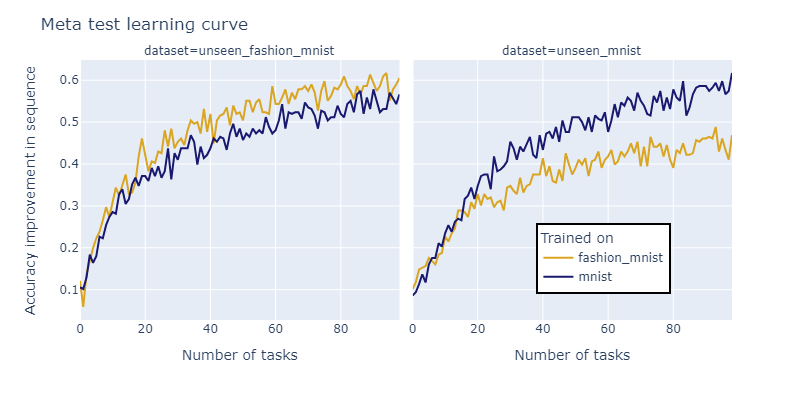

In [8]:
fig = px.line(
    res, y=0, color="trained_on", facet_col="dataset",
    color_discrete_sequence=["goldenrod", "midnightblue"]
)
fig.update_layout(
    legend=dict(
        x=0.70,
        y=0.10,
        bgcolor="white",
        bordercolor="Black",
        borderwidth=2,
        title="Trained on"
    ),
    width=700, height=400, title="Meta test learning curve",
    yaxis=dict(title="Accuracy improvement in sequence"),
)
fig.update_xaxes(title="Number of tasks")
fig.show()

И действительно, в процессе модель всё больше и больше понимает, аккураси со временем растёт. Не так внушительно, как в оригинальной статье, но всё же, значит и правда научились учиться. Но так или иначе, почему-то обучающий датасет на это влияет, но авторы в это тоже не вдаются